# IMPORT KEY LIBRARIES/DATASETS AND PREPARE THE DATA FOR TRAINING

In [2]:
# Install seaborn library
!pip install --upgrade Seaborn

# Import required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


In [3]:
# Read the data using Pandas 
icecream_sales_df = pd.read_csv('IceCreamData.csv')

In [4]:
# View the DataFrame
icecream_sales_df

,Temperature,Revenue
0,24.566884,534.799028
1,26.005191,625.190122
2,27.790554,660.632289
3,20.595335,487.706960
4,11.503498,316.240194
...,...,...
495,22.274899,524.746364
496,32.893092,755.818399
497,12.588157,306.090719
498,22.362402,566.217304


In [5]:
icecream_sales_df.head()

,Temperature,Revenue
0,24.566884,534.799028
1,26.005191,625.190122
2,27.790554,660.632289
3,20.595335,487.706960
4,11.503498,316.240194


In [6]:
icecream_sales_df.tail()

,Temperature,Revenue
495,22.274899,524.746364
496,32.893092,755.818399
497,12.588157,306.090719
498,22.362402,566.217304
499,28.957736,655.660388


In [7]:
# Separate the data into input X and output y
X = icecream_sales_df[['Temperature']]
y = icecream_sales_df[['Revenue']]

In [8]:
X

,Temperature
0,24.566884
1,26.005191
2,27.790554
3,20.595335
4,11.503498
...,...
495,22.274899
496,32.893092
497,12.588157
498,22.362402


In [9]:
y

,Revenue
0,534.799028
1,625.190122
2,660.632289
3,487.706960
4,316.240194
...,...
495,524.746364
496,755.818399
497,306.090719
498,566.217304


In [10]:
# Check out the shape of the input
X.shape

(500, 1)

In [11]:
# Check out the shape of the output
y.shape

(500, 1)

In [12]:
# Convert the datatype to float32
X = np.array(X).astype('float32')
y = np.array(y).astype('float32')

In [13]:
# split the data into training and testing(20%) using SkLearn Library
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

# TRAIN A LINEAR LEARNER MODEL USING AWS SAGEMAKER 

In [14]:
import sagemaker
import boto3

# Create a Sagemaker session
sagemaker_session = sagemaker.Session()

# Let's define the S3 bucket and prefix that we want to use in this session
bucket = 'ml-lab-sagemaker' # bucket need to be created beforehand
prefix = 'simple_linear_learner' # prefix is the subfolder within the bucket.

# Create a sagemekaer execution role
role = sagemaker.get_execution_role()
print(role)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
arn:aws:iam::588738589118:role/service-role/AmazonSageMaker-ExecutionRole-20241129T190553


In [15]:
X_train.shape

(400, 1)

In [19]:
# Make sure that the target label is a vector
y_train = y_train[:,0] 

In [20]:
y_train.shape

(400,)

In [25]:
import io # The io module allows for dealing with various types of I/O (text I/O, binary I/O and raw I/O). 
import numpy as np
import sagemaker.amazon.common as smac # sagemaker common libary

# Code below converts the data in numpy array format to RecordIO format
# This is the format required by Sagemaker Linear Learner (one of many available options!)

buf = io.BytesIO() # create an in-memory byte array (buf is a buffer I will be writing to)
smac.write_numpy_to_dense_tensor(buf, X_train, y_train)
buf.seek(0) 
# When you write to in-memory byte arrays, it increments 1 every time you write to it
# Let's reset that back to zero 


0

In [26]:
import os

# Code to upload RecordIO data to S3
 
# Key refers to the name of the file    
key = 'linear-train-data'

# The following code uploads the data in record-io format to S3 bucket to be accessed later for training
boto3.resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train', key)).upload_fileobj(buf)

# Let's print out the training data location in s3
s3_train_data = 's3://{}/{}/train/{}'.format(bucket, prefix, key)
print('uploaded training data location: {}'.format(s3_train_data))

uploaded training data location: s3://ml-lab-sagemaker/simple_linear_learner/train/linear-train-data


In [27]:
X_test.shape

(100, 1)

In [31]:
y_test.shape

(100, 1)

In [32]:
# Make sure that the target label is a vector
y_test = y_test[:,0]


In [33]:
# Code to upload RecordIO data to S3

buf = io.BytesIO() # create an in-memory byte array (buf is a buffer I will be writing to)
smac.write_numpy_to_dense_tensor(buf, X_test, y_test)
buf.seek(0) 
# When you write to in-memory byte arrays, it increments 1 every time you write to it
# Let's reset that back to zero 


0

In [34]:
# Key refers to the name of the file    
key = 'linear-test-data'

# The following code uploads the data in record-io format to S3 bucket to be accessed later for training
boto3.resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'test', key)).upload_fileobj(buf)

# Let's print out the testing data location in s3
s3_test_data = 's3://{}/{}/test/{}'.format(bucket, prefix, key)
print('uploaded training data location: {}'.format(s3_test_data))

uploaded training data location: s3://ml-lab-sagemaker/simple_linear_learner/test/linear-test-data


In [35]:
# create an output placeholder in S3 bucket to store the linear learner output

output_location = 's3://{}/{}/output'.format(bucket, prefix)
print('Training artifacts will be uploaded to: {}'.format(output_location))

Training artifacts will be uploaded to: s3://ml-lab-sagemaker/simple_linear_learner/output


In [36]:
# Obtain a reference to the linearLearner container image

container = sagemaker.image_uris.retrieve("linear-learner", boto3.Session().region_name)

In [37]:
linear = sagemaker.estimator.Estimator(container,
                                       role, 
                                       instance_count = 1, 
                                       instance_type = 'ml.m4.xlarge',
                                       output_path = output_location,
                                       sagemaker_session = sagemaker_session)

linear.set_hyperparameters(feature_dim = 1,
                           predictor_type = 'regressor',
                           mini_batch_size = 5,
                           epochs = 5,
                           num_models = 32,
                           loss = 'absolute_loss')

# Now we are ready to pass in the training data from S3 to train the linear learner model

linear.fit({'train': s3_train_data})

INFO:sagemaker:Creating training-job with name: linear-learner-2024-12-04-20-55-43-423


2024-12-04 20:55:43 Starting - Starting the training job...
2024-12-04 20:55:58 Starting - Preparing the instances for training...
2024-12-04 20:56:35 Downloading - Downloading input data...
2024-12-04 20:57:05 Downloading - Downloading the training image.........
2024-12-04 20:58:16 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
[12/04/2024 20:58:38 INFO 140003444303680] Reading default configuration from /opt/amazon/lib/python3.8/site-packages/algorithm/resources/default-input.json: {'mini_batch_size': '1000', 'epochs': '15', 'feature_dim': 'auto', 'use_bias': 'true', 'binary_classifier_model_selection_criteria': 'accuracy', 'f_beta': '1.0', 'target_recall': '0.8', 'target_precision': '0.8', 'num_models': 'auto', 'num_calibration_samples': '10000000', 'init_method': 'uniform', 'init_scale': '0.07', 'init_sigma': '0.01', 'init_bias': '0.0', 'optimizer': 'auto', 'loss'

# DEPLOY AND TEST TRAINED LINEAR LEARNER MODEL 

In [39]:
# Deploying the model to perform inference 
# serializer: A serializer object is used to encode data for an inference endpoint.
# deserializer: A deserializer object is used to decode data from an inference endpoint.

from sagemaker.deserializers import JSONDeserializer
from sagemaker.serializers import CSVSerializer


linear_regressor = linear.deploy(initial_instance_count = 1,
                                 instance_type = 'ml.m4.xlarge',
                                 serializer = CSVSerializer(),
                                 deserializer = JSONDeserializer())

INFO:sagemaker:Creating model with name: linear-learner-2024-12-04-21-01-37-765
INFO:sagemaker:Creating endpoint-config with name linear-learner-2024-12-04-21-01-37-765
INFO:sagemaker:Creating endpoint with name linear-learner-2024-12-04-21-01-37-765


---------!

In [40]:
# Making prediction on the test data
result = linear_regressor.predict(X_test)

In [41]:
result # results are in Json format

{'predictions': [{'score': 403.442626953125},
  {'score': 602.5214233398438},
  {'score': 769.68310546875},
  {'score': 675.1608276367188},
  {'score': 538.4176635742188},
  {'score': 459.13519287109375},
  {'score': 660.58984375},
  {'score': 794.7659301757812},
  {'score': 135.95718383789062},
  {'score': 441.7228698730469},
  {'score': 706.6998901367188},
  {'score': 461.1871337890625},
  {'score': 298.4532775878906},
  {'score': 537.937744140625},
  {'score': 169.12319946289062},
  {'score': 568.1857299804688},
  {'score': 484.7461853027344},
  {'score': 521.611083984375},
  {'score': 157.502197265625},
  {'score': 296.6925964355469},
  {'score': 639.1152954101562},
  {'score': 722.5765380859375},
  {'score': 145.54330444335938},
  {'score': 531.4805908203125},
  {'score': 499.4202575683594},
  {'score': 505.7557373046875},
  {'score': 216.72706604003906},
  {'score': 249.4966278076172},
  {'score': 683.3693237304688},
  {'score': 553.74951171875},
  {'score': 752.0844116210938},
 

In [42]:
# Since the result is in json format, we access the scores by iterating through the scores in the predictions
predictions = np.array([r['score'] for r in result['predictions']])

In [43]:
predictions

array([403.44262695, 602.52142334, 769.68310547, 675.16082764,
       538.41766357, 459.13519287, 660.58984375, 794.76593018,
       135.95718384, 441.72286987, 706.69989014, 461.18713379,
       298.45327759, 537.93774414, 169.12319946, 568.18572998,
       484.7461853 , 521.61108398, 157.50219727, 296.69259644,
       639.11529541, 722.57653809, 145.54330444, 531.48059082,
       499.42025757, 505.7557373 , 216.72706604, 249.49662781,
       683.36932373, 553.74951172, 752.08441162, 582.71936035,
       797.23974609, 633.34356689, 456.26895142, 652.19946289,
       564.63818359, 409.22109985, 467.7880249 , 257.10421753,
       281.46966553, 488.96838379, 703.88464355, 374.22787476,
       378.09054565, 306.1076355 , 531.11047363, 607.61218262,
       526.76812744, 753.47576904, 353.69287109, 384.20254517,
       336.60342407, 270.79458618, 731.38623047, 450.63607788,
       431.35852051, 493.16342163, 501.44561768, 493.93688965,
       757.80706787, 495.381073  , 644.00701904, 656.11

In [44]:
predictions.shape

(100,)

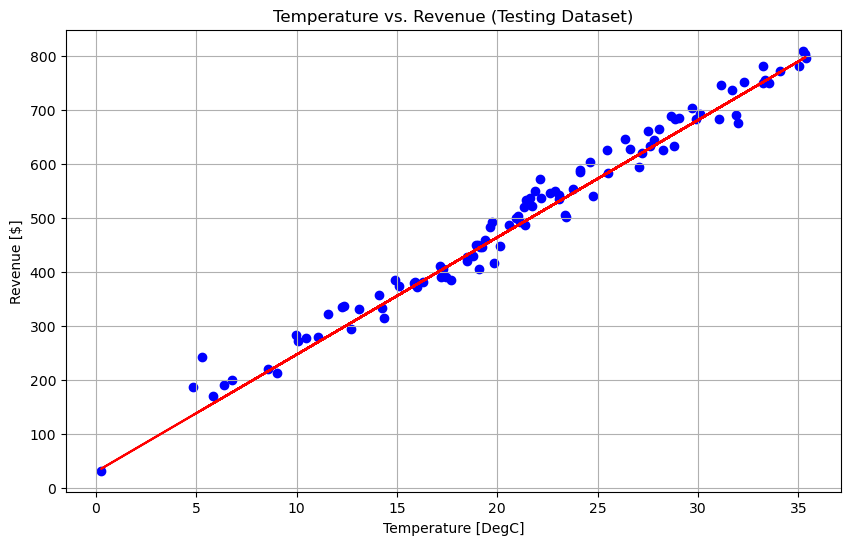

In [45]:
# VISUALIZE TEST SET RESULTS
plt.figure(figsize = (10, 6))
plt.scatter(X_test, y_test, color = 'blue')
plt.plot(X_test, predictions, color = 'red')
plt.xlabel('Temperature [DegC]')
plt.ylabel('Revenue [$]')
plt.title('Temperature vs. Revenue (Testing Dataset)')
plt.grid()

In [46]:
# Testing the model with the following temperatures: 10 degC and 35 degC
temperature = [[10]]
revenue = linear_regressor.predict(temperature)
print(revenue)

temperature = [[35]] 
revenue = linear_regressor.predict(temperature)
print(revenue)

{'predictions': [{'score': 247.39886474609375}]}
{'predictions': [{'score': 790.050537109375}]}


In [47]:
# Delete the end-point
linear_regressor.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: linear-learner-2024-12-04-21-01-37-765
INFO:sagemaker:Deleting endpoint with name: linear-learner-2024-12-04-21-01-37-765


# TRAINING A NEW MODEL WITH 25% TEST DATA AND OPTIMISED COST

In [48]:
# split the data into training and testing(25%) using SkLearn Library
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, shuffle = False)


In [49]:
X_train.shape

(375, 1)

In [50]:
X_test.shape

(125, 1)

In [51]:
y_train.shape

(375, 1)

In [52]:
y_test.shape

(125, 1)

In [54]:
linear = sagemaker.estimator.Estimator(container,
                                       role, 
                                       instance_count = 1, 
                                       instance_type = 'ml.m4.xlarge',
                                       output_path = output_location,
                                       sagemaker_session = sagemaker_session,
                                       use_spot_instances = True,
                                       max_run = 300,
                                       max_wait = 600)

linear.set_hyperparameters(feature_dim = 1,
                           predictor_type = 'regressor',
                           mini_batch_size = 5,
                           epochs = 5,
                           num_models = 32,
                           loss = 'absolute_loss')

# Now we are ready to pass in the training data from S3 to train the linear learner model

linear.fit({'train': s3_train_data})

INFO:sagemaker:Creating training-job with name: linear-learner-2024-12-04-21-09-23-429


2024-12-04 21:09:23 Starting - Starting the training job...
2024-12-04 21:09:52 Starting - Preparing the instances for training......
2024-12-04 21:10:40 Downloading - Downloading input data...
2024-12-04 21:11:11 Downloading - Downloading the training image.........
2024-12-04 21:12:32 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
[12/04/2024 21:12:48 INFO 140614134814528] Reading default configuration from /opt/amazon/lib/python3.8/site-packages/algorithm/resources/default-input.json: {'mini_batch_size': '1000', 'epochs': '15', 'feature_dim': 'auto', 'use_bias': 'true', 'binary_classifier_model_selection_criteria': 'accuracy', 'f_beta': '1.0', 'target_recall': '0.8', 'target_precision': '0.8', 'num_models': 'auto', 'num_calibration_samples': '10000000', 'init_method': 'uniform', 'init_scale': '0.07', 'init_sigma': '0.01', 'init_bias': '0.0', 'optimizer': 'auto', 'lo

In [55]:
from sagemaker.deserializers import JSONDeserializer
from sagemaker.serializers import CSVSerializer


linear_regressor = linear.deploy(initial_instance_count = 1,
                                 instance_type = 'ml.m4.xlarge',
                                 serializer = CSVSerializer(),
                                 deserializer = JSONDeserializer())

INFO:sagemaker:Creating model with name: linear-learner-2024-12-04-21-13-38-139
INFO:sagemaker:Creating endpoint-config with name linear-learner-2024-12-04-21-13-38-139
INFO:sagemaker:Creating endpoint with name linear-learner-2024-12-04-21-13-38-139


-------!

In [56]:
result = linear_regressor.predict(X_test)

In [57]:
predictions = np.array([r['score'] for r in result['predictions']])


In [58]:
predictions

array([ 665.26501465,  787.02685547,  272.95019531,  597.43609619,
        895.52893066,  473.38140869,  418.25161743,  428.57546997,
        245.23461914,  574.21148682,  292.64733887,  833.39935303,
        350.1081543 ,  184.61386108,  857.26568604,  614.74377441,
        300.21273804,  249.99786377,  411.80569458,  292.16708374,
        690.36791992,  189.56184387,  521.61108398,  639.11529541,
        757.80706787,  556.50128174,  868.81890869,   30.3381958 ,
        558.8614502 ,  598.36120605,  145.54330444,  420.98260498,
        702.46838379,  675.41027832,  739.03985596,  488.96838379,
        433.02130127,  346.18777466,  936.92657471,  618.9576416 ,
        464.81515503,  476.68035889,  627.61633301,  686.47143555,
        500.92349243,  465.54885864,  405.83584595,  403.67016602,
        799.6998291 ,  445.22042847,  441.72286987,  597.3470459 ,
        464.08764648,  632.06158447,  486.73858643,  581.24768066,
        553.74951172,  629.40533447,  220.39660645,  628.16583

In [59]:
predictions.shape

(125,)

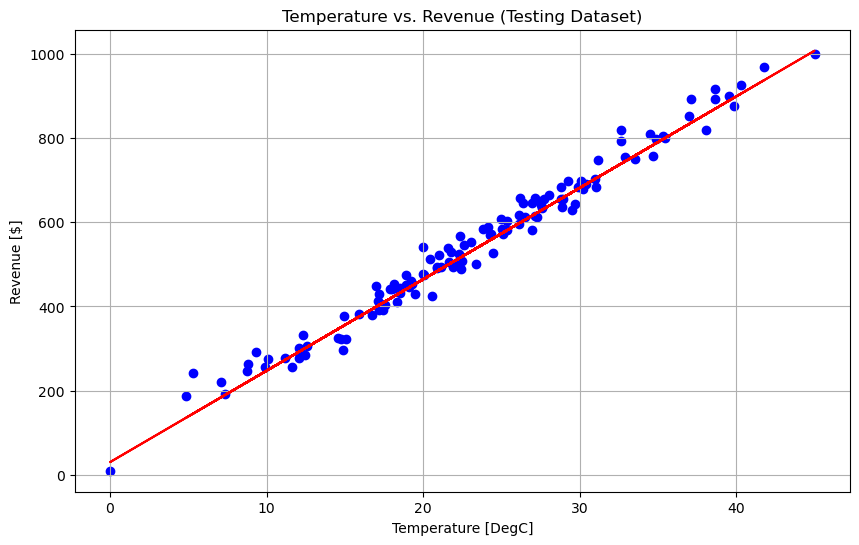

In [60]:
plt.figure(figsize = (10, 6))
plt.scatter(X_test, y_test, color = 'blue')
plt.plot(X_test, predictions, color = 'red')
plt.xlabel('Temperature [DegC]')
plt.ylabel('Revenue [$]')
plt.title('Temperature vs. Revenue (Testing Dataset)')
plt.grid()

In [61]:
temperature = [[10]]
revenue = linear_regressor.predict(temperature)
print(revenue)

temperature = [[35]] 
revenue = linear_regressor.predict(temperature)
print(revenue)


{'predictions': [{'score': 247.39886474609375}]}
{'predictions': [{'score': 790.050537109375}]}


In [70]:
# Delete the end-point
linear_regressor.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: linear-learner-2024-12-02-11-12-03-752
INFO:sagemaker:Deleting endpoint with name: linear-learner-2024-12-02-11-12-03-752


# TRAINING A MODEL WITH 25% TEST DATA MORE EPOCHS 

In [64]:
# More epochs and additional number of models
linear = sagemaker.estimator.Estimator(container,
                                       role, 
                                       instance_count = 1, 
                                       instance_type = 'ml.m4.xlarge',
                                       output_path = output_location,
                                       sagemaker_session = sagemaker_session)

linear.set_hyperparameters(feature_dim = 1,
                           predictor_type = 'regressor',
                           mini_batch_size = 5,
                           epochs = 10,
                           num_models = 32,
                           loss = 'absolute_loss')

# Now we are ready to pass in the training data from S3 to train the linear learner model

linear.fit({'train': s3_train_data})

INFO:sagemaker:Creating training-job with name: linear-learner-2024-12-04-21-19-36-472


2024-12-04 21:19:36 Starting - Starting the training job...
2024-12-04 21:19:54 Starting - Preparing the instances for training...
2024-12-04 21:20:25 Downloading - Downloading input data...
2024-12-04 21:20:55 Downloading - Downloading the training image......
2024-12-04 21:22:02 Training - Training image download completed. Training in progress....Docker entrypoint called with argument(s): train
Running default environment configuration script
[12/04/2024 21:22:26 INFO 139730080646976] Reading default configuration from /opt/amazon/lib/python3.8/site-packages/algorithm/resources/default-input.json: {'mini_batch_size': '1000', 'epochs': '15', 'feature_dim': 'auto', 'use_bias': 'true', 'binary_classifier_model_selection_criteria': 'accuracy', 'f_beta': '1.0', 'target_recall': '0.8', 'target_precision': '0.8', 'num_models': 'auto', 'num_calibration_samples': '10000000', 'init_method': 'uniform', 'init_scale': '0.07', 'init_sigma': '0.01', 'init_bias': '0.0', 'optimizer': 'auto', 'loss':

In [65]:
from sagemaker.deserializers import JSONDeserializer
from sagemaker.serializers import CSVSerializer


linear_regressor = linear.deploy(initial_instance_count = 1,
                                 instance_type = 'ml.m4.xlarge',
                                 serializer = CSVSerializer(),
                                 deserializer = JSONDeserializer())

INFO:sagemaker:Creating model with name: linear-learner-2024-12-04-21-23-54-408
INFO:sagemaker:Creating endpoint-config with name linear-learner-2024-12-04-21-23-54-408
INFO:sagemaker:Creating endpoint with name linear-learner-2024-12-04-21-23-54-408


-----------!

In [66]:
result = linear_regressor.predict(X_test)

In [67]:
predictions = np.array([r['score'] for r in result['predictions']])

In [68]:
predictions

array([ 665.26501465,  787.02685547,  272.95019531,  597.43609619,
        895.52893066,  473.38140869,  418.25161743,  428.57546997,
        245.23461914,  574.21148682,  292.64733887,  833.39935303,
        350.1081543 ,  184.61386108,  857.26568604,  614.74377441,
        300.21273804,  249.99786377,  411.80569458,  292.16708374,
        690.36791992,  189.56184387,  521.61108398,  639.11529541,
        757.80706787,  556.50128174,  868.81890869,   30.3381958 ,
        558.8614502 ,  598.36120605,  145.54330444,  420.98260498,
        702.46838379,  675.41027832,  739.03985596,  488.96838379,
        433.02130127,  346.18777466,  936.92657471,  618.9576416 ,
        464.81515503,  476.68035889,  627.61633301,  686.47143555,
        500.92349243,  465.54885864,  405.83584595,  403.67016602,
        799.6998291 ,  445.22042847,  441.72286987,  597.3470459 ,
        464.08764648,  632.06158447,  486.73858643,  581.24768066,
        553.74951172,  629.40533447,  220.39660645,  628.16583

In [69]:
predictions.shape

(125,)

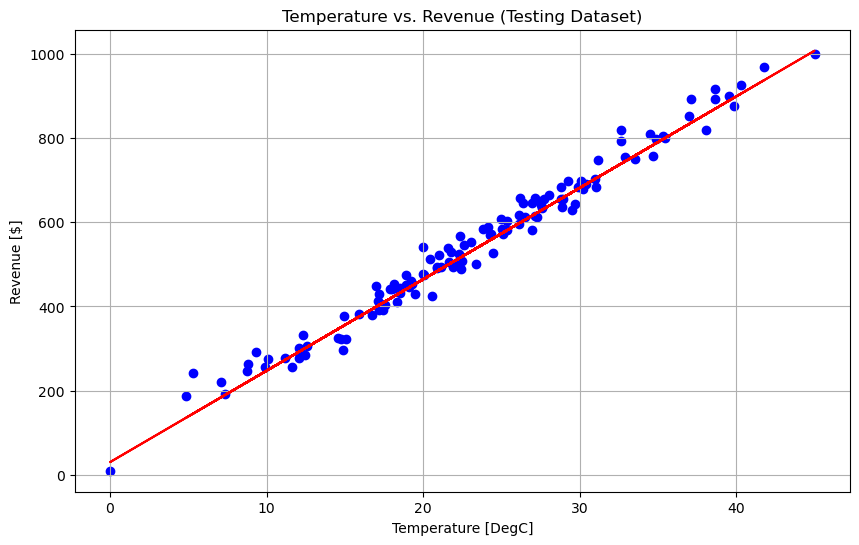

In [70]:
plt.figure(figsize = (10, 6))
plt.scatter(X_test, y_test, color = 'blue')
plt.plot(X_test, predictions, color = 'red')
plt.xlabel('Temperature [DegC]')
plt.ylabel('Revenue [$]')
plt.title('Temperature vs. Revenue (Testing Dataset)')
plt.grid()

In [71]:
temperature = [[10]]
revenue = linear_regressor.predict(temperature)
print(revenue)

temperature = [[35]] 
revenue = linear_regressor.predict(temperature)
print(revenue)

{'predictions': [{'score': 247.39886474609375}]}
{'predictions': [{'score': 790.050537109375}]}


In [72]:
linear_regressor.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: linear-learner-2024-12-04-21-23-54-408
INFO:sagemaker:Deleting endpoint with name: linear-learner-2024-12-04-21-23-54-408
